# Explora aquí

Se recomienda utilizar este cuaderno con fines de exploración.

Los datos se han guardado en "libros_populares.csv"
Se encontraron 6.tablas
                                               Libro  \
0                                        Don Quijote   
1    Historia de dos ciudades (A Tale of Two Cities)   
2    El Señor de los Anillos (The Lord of the Rings)   
3  Harry Potter y la piedra filosofal (Harry Pott...   
4                    El principito (Le Petit Prince)   

                      Autor Idioma original Primera edición  \
0       Miguel de Cervantes         Español            1605   
1           Charles Dickens          Inglés            1859   
2          J. R. R. Tolkien          Inglés            1954   
3              J.K. Rowling          Inglés            1997   
4  Antoine de Saint-Exupéry         Francés            1943   

        Ventas aproximadas  
0      Más de 500 millones  
1  Más de 200 millones[3]​  
2     150 millones[4]​[5]​  
3         140 millones[6]​  
4         140 millones[7]​  
Columnas ['Libro', 'Autor', 'Idiom

/tmp/ipykernel_733/3416353723.py:107: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Ventas aproximadas', y='Título', data=df_sorted.head(10), palette='deep', edgecolor='black')
/tmp/ipykernel_733/3416353723.py:111: UserWarning: Glyph 32418 (\N{CJK UNIFIED IDEOGRAPH-7EA2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_733/3416353723.py:111: UserWarning: Glyph 27004 (\N{CJK UNIFIED IDEOGRAPH-697C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_733/3416353723.py:111: UserWarning: Glyph 26790 (\N{CJK UNIFIED IDEOGRAPH-68A6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_733/3416353723.py:111: UserWarning: Glyph 35770 (\N{CJK UNIFIED IDEOGRAPH-8BBA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_733/3416353723.py:111: UserWarning: Glyph 19977 (\

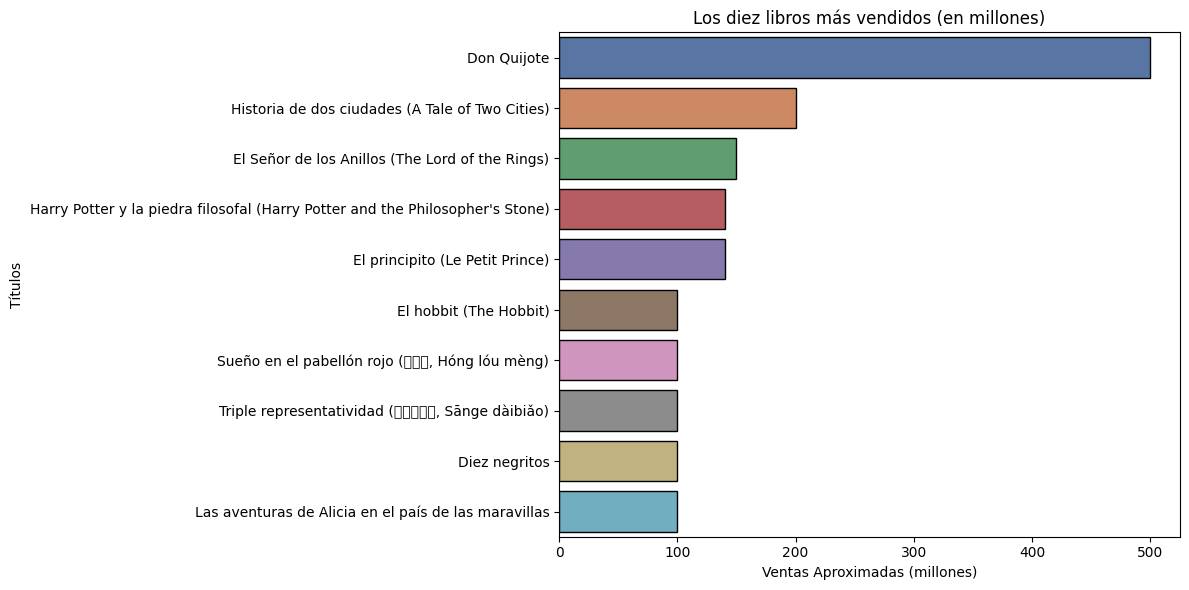

/tmp/ipykernel_733/3416353723.py:125: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=conteo_decadas.values, y=conteo_decadas.index, palette='deep', edgecolor='black')


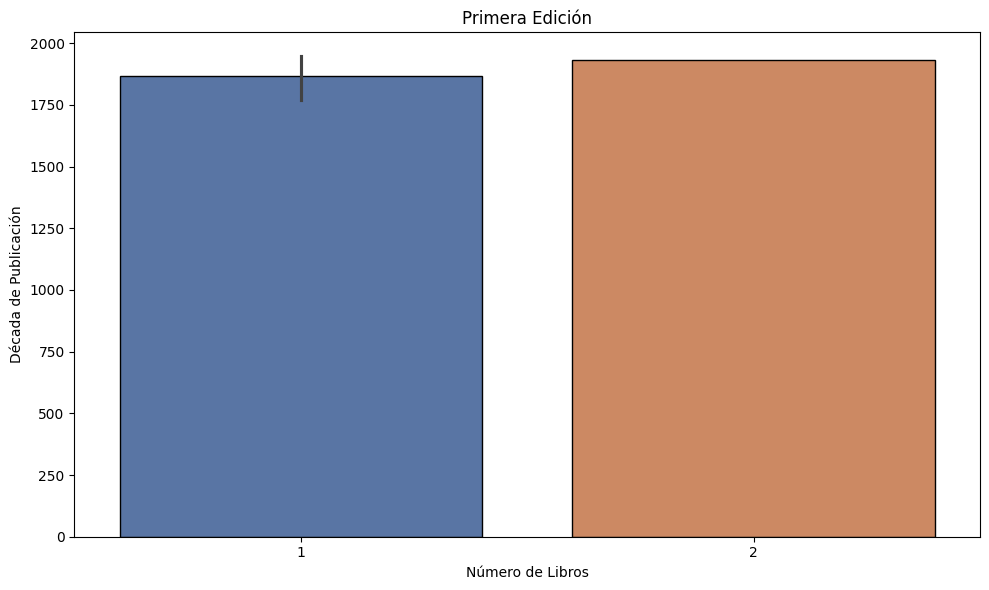

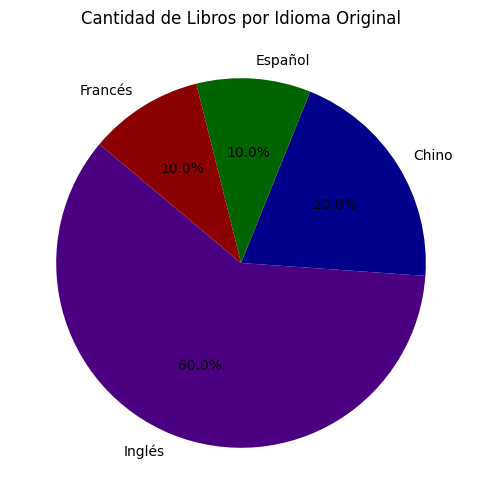

In [5]:
import os
from bs4 import BeautifulSoup
import requests
import time
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import csv  
import pandas as pd

url = 'https://es.wikipedia.org/wiki/Anexo:Libros_m%C3%A1s_vendidos'
response = requests.get(url)

if response.status_code == 200:
    soup = BeautifulSoup(response.content, 'html.parser')

    tables = soup.find_all('table', {'class': 'wikitable'})

    for table in tables:
        rows = table.find_all('tr')

    with open('libros_populares.csv', mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        
        writer.writerow(['Título', 'Autor', 'Idioma Original', 'Primera Edición', 'Ventas Aproximadas'])

        for row in rows[1:]:  
            cols = row.find_all('td')

            if len(cols) >= 5:  # Aseguramos que haya suficientes columnas (al menos 5)
                title = cols[0].get_text(strip=True) if cols[0] else 'Título no encontrado'
                author = cols[1].get_text(strip=True) if cols[1] else 'Autor no encontrado'
                language = cols[2].get_text(strip=True) if cols[2] else 'Idioma no encontrado'
                first_edition = cols[3].get_text(strip=True) if cols[3] else 'Primera Edición no encontrada'
                sales = cols[4].get_text(strip=True) if cols[4] else 'Ventas no encontradas'

                writer.writerow([title, author, language, first_edition, sales])

    print('Los datos se han guardado en "libros_populares.csv"')

else:
    print(f'Error al acceder a la página. Código de estado: {response.status_code}')

tablas = pd.read_html(url)

print(f"Se encontraron {len(tablas)}.tablas")
print(tablas[0].head())

df = tablas[0]

print("Columnas", df.columns.tolist())

df.columns = df.columns.str.strip()
print(f"Nombre de las columnas: df{df.columns}")
df = df.rename(columns={df.columns[0]: 'Título'})

for columna in df.columns:
    df[columna] = df[columna].astype(str)\
    .str.replace(r'\$', '', regex=True)\
    .str.replace('B', '', regex=True)\
    .str.replace('Más de', '', regex=True)\
    .str.replace('millones', '', regex=True)\
    .str.replace(r'\[.*?\]', '', regex=True)\
    .str.replace(r'Nota\s?\d+', '', regex=True)\
    .str.strip()

df['Ventas aproximadas'] = df['Ventas aproximadas'].str.replace(r'\s+', '', regex=True)
df['Ventas aproximadas'] = df['Ventas aproximadas'].str.replace(r'[^\d.]', '', regex=True)


conn = sqlite3.connect('libros_populares.db')
cursor = conn.cursor()

cursor.execute('''
	CREATE TABLE IF NOT EXISTS libros(
		titulo TEXT,
		autor TEXT,
		idioma TEXT,
		primera_edicion INTEGER, 
		ventas REAL
	)
''')

conn.commit()
print("Base de Datos Libros Populares")

conn.close()

print(df['Ventas aproximadas'].unique())
print(f"Valores nulos en 'Ventas aproximadas': {df['Ventas aproximadas'].isnull().sum()}")

df['Ventas aproximadas'] = pd.to_numeric(df['Ventas aproximadas'], errors='coerce')


print(f"Valores nulos tras la conversión: {df['Ventas aproximadas'].isnull().sum()}")

df['Ventas aproximadas'] = df['Ventas aproximadas'].fillna(0)

print(df.head())

# GRÁFICO 1: DIEZ LIBROS MÁS VENDIDOS

df_sorted = df.sort_values('Ventas aproximadas', ascending=False)
print(df_sorted[['Título', 'Ventas aproximadas']].head())

plt.figure(figsize=(12, 6))
sns.barplot(x='Ventas aproximadas', y='Título', data=df_sorted.head(10), palette='deep', edgecolor='black')
plt.title("Los diez libros más vendidos (en millones)")
plt.xlabel("Ventas Aproximadas (millones)")
plt.ylabel("Títulos")
plt.tight_layout()
plt.show()

# GRÁFICO 2: FECHAS DE PUBLICACIÓN

df['Primera edición'] = df['Primera edición'].str.extract(r'(\d{4})')
df['Primera edición'] = pd.to_numeric(df['Primera edición'], errors='coerce')


df_edicion = df.dropna(subset=['Primera edición'])
df_edicion['Década'] = (df_edicion['Primera edición'] // 10*10).astype(int)
conteo_decadas = df_edicion['Década'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.barplot(x=conteo_decadas.values, y=conteo_decadas.index, palette='deep', edgecolor='black')
plt.title("Primera Edición")
plt.xlabel("Número de Libros")
plt.ylabel("Década de Publicación")
plt.tight_layout()
plt.show()


# GRÁFICO 3: DISTRIBUCIÓN POR IDIOMA ORIGINAL

conteo_idioma = df['Idioma original'].value_counts()
colores = ['indigo', 'darkblue', 'darkgreen', 'darkred']

plt.figure(figsize=(10,6))
plt.pie(conteo_idioma, labels=conteo_idioma.index, autopct='%1.1f%%', colors=colores, startangle=140)
plt.title("Cantidad de Libros por Idioma Original")
plt.show()






